**Домашняя работа №5**

    Написать модель Random Forest на датасет больных сердечными болезнями (можно почистить от выбросов).

Данный датасет разобран в начале лекции 5.

Модель Random Forest при обучении дает такой метод как feature importance, используя его, можно оценить, какой параметр максимально влияет на болезнь.

    Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.

Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима). Выдвигаем гипотезу на самый важный атрибут, полученный из feature_importance (Random_Forest). И оцениваем гипотезу. И делаем вывод.

In [2]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr
import ssl
# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
%matplotlib inline

In [3]:
url="http://yustiks.ru/dataset/cardio_train.csv"
data=pd.read_csv(url,sep=";")
data.tail()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


In [28]:
print(min(data['age'])/365)
print(max(data['age'])/365)

29.583561643835615
64.96712328767123


Возраст распределён без выбросов

Тогда рост должен колебаться от 150 до 200 см (но можно взять и 210 см)

In [45]:
len(data[ (data['height']<=210) & (data['height']>=150) ])

68462

Таким образом, исключаем людей с аномальным ростом (больше 210 и меньше 150 см) 

Уберём выбросы по давлению. Зафиксированный верхний рекорд давления - 310/220 мм рт. ст, нижний - около 70/50 мм рт. ст. Учтём при этом, что если нижнее давление больше верхнего, то это означает просто смену нижнего и верхнего давления

In [63]:
data_ap_hi_less_low = data[ (data['ap_hi']<=data['ap_lo'])]
data_ap_hi_less_low = data_ap_hi_less_low[ (data_ap_hi_less_low['ap_lo']<=310) ]
data_ap_hi_less_low = data_ap_hi_less_low[ (data_ap_hi_less_low['ap_lo']>=70) ]
data_ap_hi_less_low = data_ap_hi_less_low[ (data_ap_hi_less_low['ap_hi']>=50) ]
data_ap_hi_less_low = data_ap_hi_less_low[ (data_ap_hi_less_low['ap_hi']<=220) ]
data_ap_hi_less_low.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
474,681,19099,1,156,65.0,120,150,2,1,0,0,1,0
636,913,20457,2,169,68.0,70,110,1,1,0,0,1,0
2384,3356,23361,1,154,102.0,90,150,1,1,0,0,0,1
2990,4214,21957,2,182,90.0,80,140,3,3,0,0,1,1
3447,4880,19992,2,180,80.0,80,125,3,3,1,1,1,1


Поменяем местами значения нижнего и верхнего давления

In [66]:
data_ap_hi_less_low.rename(columns={'ap_hi': 'ap_lo', 'ap_lo': 'ap_hi'})
cols = list(data_ap_hi_less_low.columns)
a, b = cols.index('ap_lo'), cols.index('ap_hi')
cols[b], cols[a] = cols[a], cols[b]
data_ap_hi_less_low = data_ap_hi_less_low[cols]

In [69]:
print(len(data_ap_hi_less_low))

103


Есть 103 человека, у которых нижнее и верхнее давление было поменяно местами и входит в границы 310/220 мм рт. ст – 70/50 мм рт. ст.

In [70]:
data_ap_hi_more_low = data[ (data['ap_hi']>data['ap_lo'])]
data_ap_hi_more_low = data_ap_hi_more_low[ (data_ap_hi_more_low['ap_hi']<=310) ]
data_ap_hi_more_low = data_ap_hi_more_low[ (data_ap_hi_more_low['ap_hi']>=70) ]
data_ap_hi_more_low = data_ap_hi_more_low[ (data_ap_hi_more_low['ap_lo']>=50) ]
data_ap_hi_more_low = data_ap_hi_more_low[ (data_ap_hi_more_low['ap_lo']<=220) ]
data_ap_hi_more_low.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [71]:
print(len(data_ap_hi_more_low))

68652


68652 человека, у которых давление укладывается в пределы, установленные ранее

In [74]:
print(len(data_ap_hi_more_low)+len(data_ap_hi_less_low))

68755


Объединим очищенные от выбросов по давлению датасеты

In [76]:
data_pressure = data_ap_hi_more_low.merge(data_ap_hi_less_low, how='outer')
data_pressure.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Теперь отфильтруем по росту (рассмотрено ранее)

In [78]:
data_filtered = data_pressure[(data_pressure['height']<=210) & (data_pressure['height']>=150)]
data_filtered.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [102]:
cols = list(data_filtered.columns)
a, b = cols.index('ap_lo'), cols.index('gender')
cols[b], cols[a] = cols[a], cols[b]
data_filtered = data_filtered[cols]
data_filtered.head()

,id,age,ap_lo,height,weight,ap_hi,gender,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,80,168,62.0,110,2,1,1,0,0,1,0
1,1,20228,90,156,85.0,140,1,3,1,0,0,1,1
2,2,18857,70,165,64.0,130,1,3,1,0,0,0,1
3,3,17623,100,169,82.0,150,2,1,1,0,0,1,1
4,4,17474,60,156,56.0,100,1,1,1,0,0,0,0


In [79]:
print(70000-len(data_filtered))

2751


Отсеяно 2751 человек

Все столбцы, кроме id, служат параметрами для предсказания сердеченого заболевания (столбец **cardio**)

In [82]:
params = data_filtered.iloc[:,1:12]
params.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18393,2,168,62.0,110,80,1,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1
2,18857,1,165,64.0,130,70,3,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0


In [86]:
target = data_filtered.iloc[:,12:]
target.head()

,cardio
0,0
1,1
2,1
3,1
4,0


Нормализуем данные в параметрах

In [88]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

np_scaled = min_max_scaler.fit_transform(params)
params_norm = pd.DataFrame(np_scaled)
params_norm.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.176152,1.0,-0.368421,-0.460317,-0.529412,-0.571429,-1.0,-1.0,-1.0,-1.0,1.0
1,0.460317,-1.0,-0.789474,-0.216931,-0.176471,-0.428571,1.0,-1.0,-1.0,-1.0,1.0
2,0.248006,-1.0,-0.473684,-0.439153,-0.294118,-0.714286,1.0,-1.0,-1.0,-1.0,-1.0
3,0.056911,1.0,-0.333333,-0.248677,-0.058824,-0.285714,-1.0,-1.0,-1.0,-1.0,1.0
4,0.033837,-1.0,-0.789474,-0.523810,-0.647059,-0.857143,-1.0,-1.0,-1.0,-1.0,-1.0


In [91]:
headers = list(params.columns.values)
params_norm.columns = headers
params_norm.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0.176152,1.0,-0.368421,-0.460317,-0.529412,-0.571429,-1.0,-1.0,-1.0,-1.0,1.0
1,0.460317,-1.0,-0.789474,-0.216931,-0.176471,-0.428571,1.0,-1.0,-1.0,-1.0,1.0
2,0.248006,-1.0,-0.473684,-0.439153,-0.294118,-0.714286,1.0,-1.0,-1.0,-1.0,-1.0
3,0.056911,1.0,-0.333333,-0.248677,-0.058824,-0.285714,-1.0,-1.0,-1.0,-1.0,1.0
4,0.033837,-1.0,-0.789474,-0.523810,-0.647059,-0.857143,-1.0,-1.0,-1.0,-1.0,-1.0


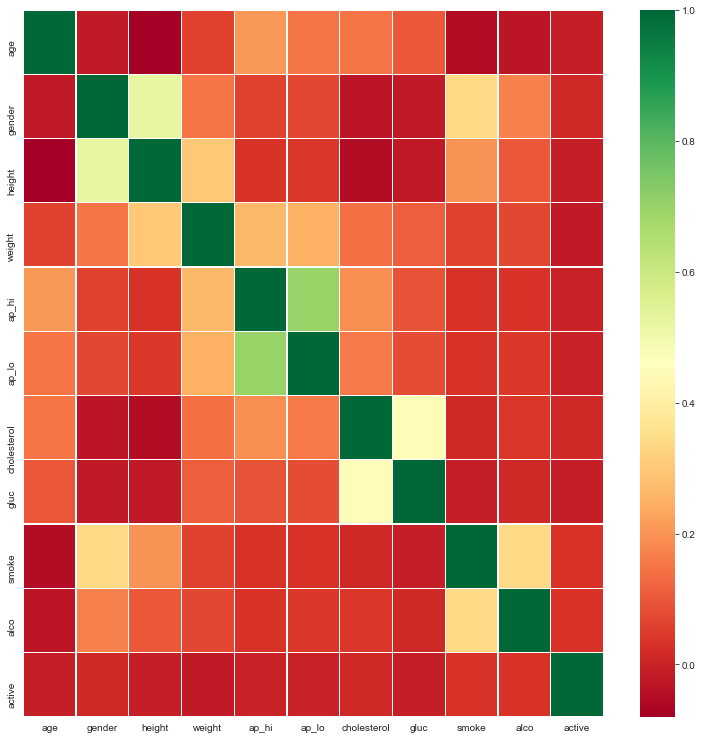

In [92]:
f, ax = plt.subplots(figsize=(13, 13))
corr = np.round_(params_norm.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlGn',linewidths=0.2)

Сильно коррелирующих между собой параметров нет

In [93]:
output_y = target
input_x = params_norm

In [104]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1)
#print(targets.value_counts())
Y=le.fit_transform(targets)

C:\Users\artem\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [105]:
from sklearn.model_selection import train_test_split
X_train_22, X_test_22, y_train_22, y_test_22 = train_test_split(input_x, Y, test_size=0.3)

In [106]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train_22,y_train_22)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

No handles with labels found to put in legend.


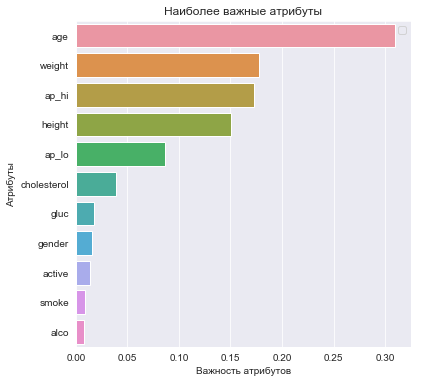

In [107]:
headers = list(X_train_22.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

In [108]:
from sklearn.metrics import classification_report
model_pred = model.predict(X_test_22)

print(classification_report(y_test_22, model_pred))

model.score(X_test_22, y_test_22)

              precision    recall  f1-score   support

           0       0.71      0.73      0.72     10276
           1       0.71      0.69      0.70      9899

    accuracy                           0.71     20175
   macro avg       0.71      0.71      0.71     20175
weighted avg       0.71      0.71      0.71     20175



0.7132589838909541

Точность предсказания 71,3%, а самый важный параметр - возраст. Теперь необходимо проверить гипотезу о том, что старые люди больше подвержены болезни сердца

В датасете возраст людей от 29 до почти 65 лет

In [138]:
import statistics
print('Мода возраста: ', statistics.median(data_filtered['age'])/365.25)

Мода возраста:  53.91101984941821


Почти 54 года 

In [139]:
median = statistics.median(data_filtered['age'])

In [140]:
old = data_filtered[data_filtered['age']>=median].cardio
young = data_filtered[data_filtered['age']<median].cardio

In [141]:
import researchpy as rp
descriptives, results = rp.ttest(old, young)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  33633.0  0.590313  0.491783  0.002682   0.585057  0.595569
1    cardio  33616.0  0.397549  0.489398  0.002669   0.392317  0.402781
2  combined  67249.0  0.493955  0.499967  0.001928   0.490176  0.497734
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =       0.1928
1            Degrees of freedom =   67247.0000
2                             t =      50.9470
3         Two side test p value =       0.0000
4        Difference < 0 p value =       1.0000
5        Difference > 0 p value =       0.0000
6                     Cohen's d =       0.3929
7                     Hedge's g =       0.3929
8                 Glass's delta =       0.3920
9                             r =       0.1928


 Difference > 0 p value меньше 0.05, значит, гипотеза